In [1]:
"""
#Task: Predict the change in energy of the structure given the host structure (xyz data (which contains the x,y,z coordinates of each atom in the structure) + element list data (which contains the elements within the structure and match up in order with their corresponding coordinates in space as the xyz data coordinates)) and the index of the molecule that is removed (use hot one encoding to represent the molecule that was removed: Mo: Molybdenum, S: Sulfur, Se: Selenium, Te: Tellurium, W: Tungsten)

#Machine Learning Task Type: Deep Learning Neural Network that learns a relationship between the associated change in the structure of the host and the corresponding change in energy of the structure
"""

'\n#Task: Predict the change in energy of the structure given the host structure (xyz data (which contains the x,y,z coordinates of each atom in the structure) + element list data (which contains the elements within the structure and match up in order with their corresponding coordinates in space as the xyz data coordinates)) and the index of the molecule that is removed (use hot one encoding to represent the molecule that was removed: Mo: Molybdenum, S: Sulfur, Se: Selenium, Te: Tellurium, W: Tungsten)\n\n#Machine Learning Task Type: Deep Learning Neural Network that learns a relationship between the associated change in the structure of the host and the corresponding change in energy of the structure\n'

In [2]:
#import python/ml packages

import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, LSTM
from tensorflow.keras.models import Model
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
#Step 1: 
folder_path = '/Users/robertspataru/Desktop/project_newData'
output_file = 'vac_origHost_compiled.csv'
csv_files = ['vac_Mo_origHost.csv', 'vac_S_origHost.csv', 'vac_Se_origHost.csv', 'vac_Te_origHost.csv', 'vac_W_origHost.csv']
column_names = ['Structure_Combination', 'Atom_Removed_Location', 'Energy_Value_Change']  

possible_elements_removed = ['Mo', 'S', 'Se', 'Te', 'W']
dfs_vac_origHost = []
for file_name in csv_files:
    full_file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(full_file_path, header = None)
    df.columns = column_names
    dfs_vac_origHost.append(df)
df_vac_origHost = pd.concat(dfs_vac_origHost, ignore_index = True)
print(df_vac_origHost.head())

  Structure_Combination  Atom_Removed_Location  Energy_Value_Change
0                   1_1                      7              -6.8879
1                   1_1                      3              -7.0395
2                   1_1                      1              -6.3746
3                  1_11                      2              -5.4809
4                  1_11                     13              -4.8951


In [4]:
#Step 2: 

input_file = '/Users/robertspataru/Desktop/project_newData/CIFhost_generic_compiled.txt'
output_file = 'CIFhost_generic_compiled.csv'

initial_column_names = ['Atom_Name', 'X-Coordinate', 'Y-Coordinate', 'Z-Coordinate']
orig_df_CIFs_sorted = []

orig_df_CIFs_sorted = pd.read_csv(input_file, sep = '\s+', header = None)
orig_df_CIFs_sorted.columns = initial_column_names

(orig_df_CIFs_sorted.head())

,Atom_Name,X-Coordinate,Y-Coordinate,Z-Coordinate
0,Mo,-0.000,0.00408,0.49999
1,Mo,0.125,0.25408,0.49999
2,Mo,0.250,0.00408,0.49999
3,Mo,0.375,0.25408,0.49999
4,Mo,0.500,0.00408,0.49999


In [5]:
#Step #3:

middle_column_names = ['Atom_Name','Structure_Combination', 'Atom_Location', 'X-Coordinate', 'Y-Coordinate', 'Z-Coordinate']
mid_df_CIFs_sorted = orig_df_CIFs_sorted

Atom_Location_List = []
Structure_Combination_List = []

x = 1
y = 1
num_rows = len(orig_df_CIFs_sorted.index)

for i in range(num_rows):
    # Append the current atom location, resetting to 1 after every 48 atoms
    Atom_Location_List.append((i % 48) + 1)
    
    # Construct the structure combination string and append it to the list
    Structure_Combination_List.append(f"{x}_{y}")
    
    # Check if we've reached the end of a structure combination (every 48 atoms)
    if (i + 1) % 48 == 0:
        y += 1  # Increment y after every 48 atoms
        if y > 72:
            y = 1  # Reset y back to 1 after reaching 72
            x += 1  # Increment x when y resets


mid_df_CIFs_sorted.insert(loc = 1, column = middle_column_names[1], value = Structure_Combination_List)
mid_df_CIFs_sorted.insert(loc = 2, column = middle_column_names[2], value = Atom_Location_List)

print(mid_df_CIFs_sorted.head())

  Atom_Name Structure_Combination  Atom_Location  X-Coordinate  Y-Coordinate  \
0        Mo                   1_1              1        -0.000       0.00408   
1        Mo                   1_1              2         0.125       0.25408   
2        Mo                   1_1              3         0.250       0.00408   
3        Mo                   1_1              4         0.375       0.25408   
4        Mo                   1_1              5         0.500       0.00408   

   Z-Coordinate  
0       0.49999  
1       0.49999  
2       0.49999  
3       0.49999  
4       0.49999  


In [6]:
#Step #4: 

mid_2_column_names = ['Atom_Name_Vector', 'Structure_Combination', 'Atom_Location', 'Coordinate_Vector']
mid_2_df_CIFs_sorted = mid_df_CIFs_sorted

Atom_Name_Column = mid_2_df_CIFs_sorted['Atom_Name']
Atom_Name_Vector_List = []
for atom in Atom_Name_Column:
    atom_name_vector = [0] * len(possible_elements_removed)
    index_to_encode = possible_elements_removed.index(atom)
    atom_name_vector[index_to_encode] = 1
    Atom_Name_Vector_List.append(atom_name_vector)

Coordinate_Vector_List = []
for i in range(num_rows):
    coordinate_vector = [mid_2_df_CIFs_sorted.loc[i, 'X-Coordinate'], mid_2_df_CIFs_sorted.loc[i, 'Y-Coordinate'], mid_2_df_CIFs_sorted.loc[i, 'Z-Coordinate']]
    Coordinate_Vector_List.append(coordinate_vector)

mid_2_df_CIFs_sorted['Atom_Name'] = Atom_Name_Vector_List
mid_2_df_CIFs_sorted.rename(columns = {'Atom_Name': 'Atom_Name_Vector'}, inplace = True)

mid_2_df_CIFs_sorted.drop(['X-Coordinate', 'Y-Coordinate', 'Z-Coordinate'], axis = 1, inplace = True)
mid_2_df_CIFs_sorted['Coordinate_Vector'] = Coordinate_Vector_List

print(mid_2_df_CIFs_sorted.head())

  Atom_Name_Vector Structure_Combination  Atom_Location  \
0  [1, 0, 0, 0, 0]                   1_1              1   
1  [1, 0, 0, 0, 0]                   1_1              2   
2  [1, 0, 0, 0, 0]                   1_1              3   
3  [1, 0, 0, 0, 0]                   1_1              4   
4  [1, 0, 0, 0, 0]                   1_1              5   

           Coordinate_Vector  
0   [-0.0, 0.00408, 0.49999]  
1  [0.125, 0.25408, 0.49999]  
2   [0.25, 0.00408, 0.49999]  
3  [0.375, 0.25408, 0.49999]  
4    [0.5, 0.00408, 0.49999]  


In [7]:
final_column_names = ['Atom_Name_Vector_List','Structure_Combination', 'Atom_Location_Vector_List','Coordinate_Vector_List']
final_df_CIFs_sorted = pd.DataFrame()

atom_name_vector_list = []
temp_atom_name_vector_list = []

structure_combination_list = []

atom_location_vector_list = []
temp_atom_location_vector_list = []

coordinate_vector_list = []
temp_coordinate_vector_list = []


for row_index in range(1, num_rows + 1):
        temp_atom_name_vector_list.append(mid_2_df_CIFs_sorted.iloc[row_index - 1]['Atom_Name_Vector'])
        
        temp_atom_location_vector_list.append(mid_2_df_CIFs_sorted.iloc[row_index - 1]['Atom_Location'])
        
        temp_coordinate_vector_list.append(mid_2_df_CIFs_sorted.iloc[row_index - 1]['Coordinate_Vector'])
        
        if row_index % 48 == 0:
            atom_name_vector_list.append(temp_atom_name_vector_list)
            temp_atom_name_vector_list = []
            
            structure_combination_list.append(mid_2_df_CIFs_sorted.iloc[row_index - 1]['Structure_Combination'])
        
            atom_location_vector_list.append(temp_atom_location_vector_list)
            temp_atom_location_vector_list = []
        
            coordinate_vector_list.append(temp_coordinate_vector_list)
            temp_coordinate_vector_list = []

final_df_CIFs_sorted['Atom_Name_Vector_List'] = atom_name_vector_list

final_df_CIFs_sorted['Structure_Combination'] = structure_combination_list

final_df_CIFs_sorted['Atom_Location_Vector_List'] = atom_location_vector_list

final_df_CIFs_sorted['Coordinate_Vector_List'] = coordinate_vector_list


print(final_df_CIFs_sorted.head())

#print(atom_name_vector_list[0])
#print(structure_combination_list[0])
#print(atom_location_vector_list[0])
#print(coordinate_vector_list[0])

                               Atom_Name_Vector_List Structure_Combination  \
0  [[1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0...                   1_1   
1  [[1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0...                   1_2   
2  [[0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [1, 0, 0, 0...                   1_3   
3  [[1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0...                   1_4   
4  [[1, 0, 0, 0, 0], [0, 0, 0, 0, 1], [1, 0, 0, 0...                   1_5   

                           Atom_Location_Vector_List  \
0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
1  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
2  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
3  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
4  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                              Coordinate_Vector_List  
0  [[-0.0, 0.00408, 0.49999], [0.125, 0.25408, 0....  
1  [[-0.0, 0.00408, 0.49999], [0.125, 0.25408, 0....  
2  [[-0.0, 0.00408, 0.49999],

In [8]:
#Combine both of the pandas dataframes into one large .csv file by going through each sentence of the combined .csv file and then matching the specific structure combination with the corresponding 48 atoms and their coordinate space. Then, delete the duplicate column that contains the structure combination in the form x_y.
final_data_df = pd.merge(df_vac_origHost, final_df_CIFs_sorted, on = 'Structure_Combination', how = 'left')
final_data_df = final_data_df[['Structure_Combination', 'Atom_Removed_Location', 'Atom_Name_Vector_List', 'Atom_Location_Vector_List', 'Coordinate_Vector_List', 'Energy_Value_Change']]
final_data_df.to_csv('final_data.csv', index = False)
print(final_data_df.head())

  Structure_Combination  Atom_Removed_Location  \
0                   1_1                      7   
1                   1_1                      3   
2                   1_1                      1   
3                  1_11                      2   
4                  1_11                     13   

                               Atom_Name_Vector_List  \
0  [[1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0...   
1  [[1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0...   
2  [[1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0...   
3  [[1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0...   
4  [[1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0...   

                           Atom_Location_Vector_List  \
0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
1  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
2  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
3  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
4  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                         

In [9]:
# Disable those annoying warnings
tf.get_logger().setLevel('ERROR')

# Turn off GPU usage for tf
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '2'

In [10]:
def pad_sequence_column(column):
    # Convert column to a list of sequences
    sequences = final_data_df[column].tolist()
    # Pad sequences
    padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, padding="post", dtype='float32')
    return padded_sequences

def prep_data(final_data_df):
    encoder = OneHotEncoder(sparse=False)
    structure_combination_encoded = encoder.fit_transform(final_data_df[['Structure_Combination']])
    # Convert encoded data into a DataFrame
    structure_combination_encoded_df = pd.DataFrame(structure_combination_encoded, 
                                                columns=encoder.get_feature_names_out(['Structure_Combination']))

    scaler = StandardScaler()
    atom_removed_location_scaled = scaler.fit_transform(final_data_df[['Atom_Removed_Location']])

    # Pad each relevant column
    atom_name_vector_list_padded = pad_sequence_column('Atom_Name_Vector_List')
    atom_location_vector_list_padded = pad_sequence_column('Atom_Location_Vector_List')
    coordinate_vector_list_padded = pad_sequence_column('Coordinate_Vector_List')
    
    X_structured = np.concatenate([structure_combination_encoded_df, atom_removed_location_scaled], axis=1)
    
    energy_value_change = final_data_df['Energy_Value_Change']
    
    return atom_name_vector_list_padded, atom_location_vector_list_padded, coordinate_vector_list_padded, X_structured, energy_value_change
    
def split_data(atom_name_vector_list_padded, atom_location_vector_list_padded, coordinate_vector_list_padded, X_structured, energy_value_change):
    # First, split the structured data (X_structured) and the target (energy_value_change)
    X_structured_train, X_structured_test, y_train, y_test = train_test_split(X_structured, energy_value_change, test_size=0.2, random_state=42)
    
    # Split each sequence data type similarly, ensuring the same indices are used by setting the same random_state
    atom_name_train, atom_name_test = train_test_split(atom_name_vector_list_padded, test_size=0.2, random_state=42)
    atom_location_train, atom_location_test = train_test_split(atom_location_vector_list_padded, test_size=0.2, random_state=42)
    coordinate_train, coordinate_test = train_test_split(coordinate_vector_list_padded, test_size=0.2, random_state=42)
    
    # Structure the training and testing data as lists of inputs to match the model's expectations
    X_train = [X_structured_train, atom_name_train, atom_location_train, coordinate_train]
    X_test = [X_structured_test, atom_name_test, atom_location_test, coordinate_test]
    
    return X_train, X_test, y_train, y_test

In [11]:
def build_model(atom_name_vector_list_padded, atom_location_vector_list_padded, coordinate_vector_list_padded, X_structured):
    # Assuming your structured data has a shape of (None, N), where N is the number of features
    input_structured = Input(shape=(X_structured.shape[1],), name='Structured_Input')

    # Assuming the sequences have been padded to the same length but might have different widths (features)
    input_atom_name = Input(shape=(atom_name_vector_list_padded.shape[1], atom_name_vector_list_padded.shape[2]), name='Atom_Name_Input')
    input_atom_location = Input(shape=(atom_location_vector_list_padded.shape[1],), name='Atom_Location_Input')  # Adjust the shape based on actual padding
    input_coordinate = Input(shape=(coordinate_vector_list_padded.shape[1], coordinate_vector_list_padded.shape[2]), name='Coordinate_Input')
    
    # Example processing layers for each input type
    atom_name_processed = LSTM(32)(input_atom_name)
    atom_location_processed = Dense(32, activation='relu')(input_atom_location)
    coordinate_processed = LSTM(32)(input_coordinate)
    
    combined = Concatenate()([input_structured, atom_name_processed, atom_location_processed, coordinate_processed])
    
    x = Dense(64, activation='relu')(combined)
    x = Dense(32, activation='relu')(x)
    
    output = Dense(1, name='Output')(x)
    
    model = Model(inputs=[input_structured, input_atom_name, input_atom_location, input_coordinate], outputs=[output])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    
    return model

In [12]:
def plot_info(history):
    # Plot training & validation loss values
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    # Plot training & validation MAE values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train')
    plt.plot(history.history['val_mae'], label='Validation')
    plt.title('Model MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [13]:
### The main function below drives the entire code. It prepares the dataset, builds a model with appropriate parameters, evaluates the model and predicts on the test data. Finally, plots some performance metrics.
def main():
    raw_df = final_data_df
    atom_name_vector_list_padded, atom_location_vector_list_padded, coordinate_vector_list_padded, X_structured, energy_value_change = prep_data(raw_df)

    # Build a DL model
    model = build_model(atom_name_vector_list_padded, atom_location_vector_list_padded, coordinate_vector_list_padded, X_structured)

    num_epochs = 10
    batch_size = 32
    earlystop_callback = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.0001, patience = 10)
    
    
    X_train, X_test, y_train, y_test = split_data(atom_name_vector_list_padded, atom_location_vector_list_padded, coordinate_vector_list_padded, X_structured, energy_value_change)
    
    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, callbacks = [earlystop_callback], validation_split = 0.2, verbose = 1)
    
    score = model.evaluate(X_test, y_test, verbose=0)
    print(f'Test loss: {score[0]}')
    print(f'Test accuracy: {score[1]}')

    y_pred = model.predict(X_test)
    # Assuming y_true contains the actual values and y_pred contains the model's predictions

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R-squared (R²): {r2}")
   
    plot_info(history)

/Users/robertspataru/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/10
75/75 [==============================] - 2s 12ms/step - loss: 1.8105 - mae: 1.0992 - val_loss: 1.2937 - val_mae: 0.9399
Epoch 2/10
75/75 [==============================] - 0s 5ms/step - loss: 1.1285 - mae: 0.8717 - val_loss: 0.9271 - val_mae: 0.8127
Epoch 3/10
75/75 [==============================] - 0s 6ms/step - loss: 0.9362 - mae: 0.7920 - val_loss: 1.2518 - val_mae: 0.8810
Epoch 4/10
75/75 [==============================] - 0s 5ms/step - loss: 0.8264 - mae: 0.7329 - val_loss: 0.7051 - val_mae: 0.6941
Epoch 5/10
75/75 [==============================] - 0s 5ms/step - loss: 0.7263 - mae: 0.6914 - val_loss: 0.7252 - val_mae: 0.6940
Epoch 6/10
75/75 [==============================] - 1s 8ms/step - loss: 0.6423 - mae: 0.6396 - val_loss: 0.6595 - val_mae: 0.6739
Epoch 7/10
75/75 [==============================] - 1s 10ms/step - loss: 0.6021 - mae: 0.6185 - val_loss: 0.7526 - val_mae: 0.6847
Epoch 8/10
75/75 [==============================] - 0s 6ms/step - loss: 0.5538 - mae: 0.

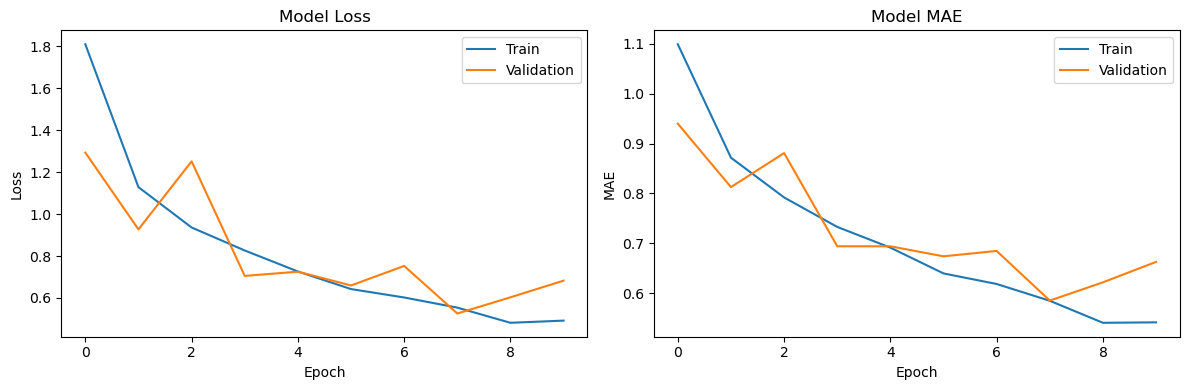

In [14]:
  if __name__ == '__main__':
    main()